In [456]:
import psycopg2 # database connection
import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # create plots
from scipy import stats # math
from IPython.display import display # display the final plot
import config # fstore/access database credentials

In [433]:
# define the database connection, and map credentials to the config.py file
conn = psycopg2.connect(host=config.host, port=5432, dbname=config.db_name, user=config.db_user, password=config.db_pw)

In [434]:
# creates cursor class to execute PostgreSQL command
cur = conn.cursor()

In [435]:
# Get average temp for each summer month (June, July, & August)
# Set variable for SQL query
sql_avg_summer_temps = """
        SELECT 
            EXTRACT(YEAR FROM datetime) AS year, 
	    CASE EXTRACT(MONTH FROM datetime)
            WHEN 6 THEN 'June'
            WHEN 7 THEN 'July'
		    WHEN 8 THEN 'August'
            END AS month,
	    AVG(temp) AS avg_summer_temp
        FROM
	        houston_historical
        WHERE
	        EXTRACT(MONTH FROM datetime) IN (6, 7, 8)
        GROUP BY
	        EXTRACT(YEAR FROM datetime),
	        EXTRACT(MONTH FROM datetime)
        ORDER BY
	        year ASC
      """

In [436]:
# Get average temp for each winter month (December, January, & February)
# Set variable for SQL query
sql_avg_winter_temps = """
      SELECT 
            EXTRACT(YEAR FROM datetime) AS year, 
	      CASE EXTRACT(MONTH FROM datetime)
                  WHEN 12 THEN 'December'
                  WHEN 1 THEN 'January'
		      WHEN 2 THEN 'February'
                  END AS month,
	      AVG(temp) AS avg_winter_temp
      FROM
            houston_historical
      WHERE
            EXTRACT(MONTH FROM datetime) IN (12, 1, 2)
      GROUP BY
            EXTRACT(YEAR FROM datetime),
            EXTRACT(MONTH FROM datetime)
      ORDER BY
            year ASC
      """

In [437]:
# Create empty dictionary
sql = {}

In [438]:
# Define key-value pairs for SQL queries
sql['sql_avg_summer_temps'] = sql_avg_summer_temps
sql['sql_avg_winter_temps'] = sql_avg_winter_temps

In [439]:
# Function to query the database, return results, and put in dataframes
def create_seasonal_df():
    global df_sql_avg_summer_temps #set as gloal var
    global df_sql_avg_winter_temps # set as global var
    for key, value in sql.items():
        cur.execute(value)
        query_results = cur.fetchall()
        cols = [desc[0] for desc in cur.description]
        df_name = f"df_{key}_temps"
        globals()[df_name] = pd.DataFrame(data=query_results, columns=cols)
        
create_seasonal_df()

In [440]:
# Close cursor class and db connection
cur.close()
conn.close()

In [441]:
# set vars
df_sql_avg_summer_temps = df_sql_avg_summer_temps
df_sql_avg_winter_temps = df_sql_avg_winter_temps

In [442]:
# Function to convert year and temp columns to numeric (float) data type from object data type
def convert_columns_to_numeric(dataframes, column_names):
    for df in dataframes:
        for column in column_names:
            if column in df.columns:
                df[column] = pd.to_numeric(df[column])
            else:
                print(f"Column '{column}' not found in dataframe.")

In [443]:
dataframes = [df_sql_avg_summer_temps, df_sql_avg_winter_temps] # list of dataframes
columns = ['avg_summer_temp', 'avg_winter_temp', 'year'] # list of columns
convert_columns_to_numeric(dataframes, columns) # call function and pass through vars

Column 'avg_winter_temp' not found in dataframe.
Column 'avg_summer_temp' not found in dataframe.


In [444]:
# print dataframes for viewing
print(df_sql_avg_summer_temps)
print(df_sql_avg_winter_temps)

       year   month  avg_summer_temp
0    1973.0    June        79.450000
1    1973.0    July        82.687097
2    1973.0  August        79.577419
3    1974.0    June        79.963333
4    1974.0    July        81.651613
..      ...     ...              ...
145  2021.0    July        82.612903
146  2021.0  August        84.141935
147  2022.0    June        84.510000
148  2022.0    July        85.619355
149  2022.0  August        83.135484

[150 rows x 3 columns]
       year     month  avg_winter_temp
0    1973.0   January        48.606452
1    1973.0  February        51.682143
2    1973.0  December        54.558065
3    1974.0   January        56.093548
4    1974.0  February        57.500000
..      ...       ...              ...
147  2022.0   January        53.951613
148  2022.0  February        52.357143
149  2022.0  December        58.096774
150  2023.0   January        60.064516
151  2023.0  February        61.132143

[152 rows x 3 columns]


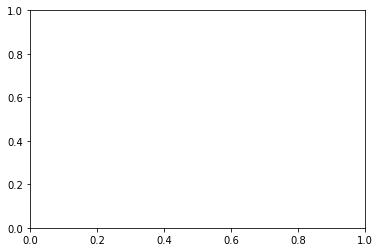

In [445]:
# define figure and axes objects 
fig, ax = plt.subplots()

In [446]:
# define scatter plot and attributes
ax.scatter(df_sql_avg_summer_temps['year'], df_sql_avg_summer_temps['avg_summer_temp'], marker = '.', label='Annual Average Summer Temp', color='#f68806')
ax.scatter(df_sql_avg_winter_temps['year'], df_sql_avg_winter_temps['avg_winter_temp'], marker = '.', label='Annual Average Winter Temp', color = '#3378b6')

In [447]:
# create trend line (line of best fit) for avg summer temps
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sql_avg_summer_temps['year'], df_sql_avg_summer_temps['avg_summer_temp'])
trend_line = intercept + slope * df_sql_avg_summer_temps['year']

In [448]:
# plot summer temps trend line
ax.plot(df_sql_avg_summer_temps['year'], trend_line, color='r')

In [449]:
# create trend line (line of best fit) for avg winter temps
slope, intercept, r_value, p_value, std_err = stats.linregress(df_sql_avg_winter_temps['year'], df_sql_avg_winter_temps['avg_winter_temp'])
trend_line = intercept + slope * df_sql_avg_winter_temps['year']

In [450]:
# plot winter temps trend line
ax.plot(df_sql_avg_winter_temps['year'], trend_line, color='r')

In [451]:
# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Average Seasonal Temperature')
ax.set_title('Average Seasonal Temperatures - Houston, TX 1973-2023')

Text(0.5, 1.0, 'Average Seasonal Temperatures - Houston, TX 1973-2023')

In [452]:
# enable legend
ax.legend()

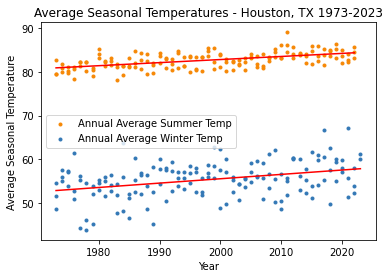

In [453]:
# show final plot
display(fig)

In [458]:
# Linear regression for avg_summer_temps dataframe
summer_results = stats.linregress(df_sql_avg_summer_temps['year'], df_sql_avg_summer_temps['avg_summer_temp'])
print(summer_results)

LinregressResult(slope=0.07016782454917449, intercept=-57.56097075561402, rvalue=0.5557496627007515, pvalue=1.5593136934506745e-13, stderr=0.00862803081362264, intercept_stderr=17.234941303395868)


In [459]:
# Linear regression for avg_winter_temps dataframe
winter_results = stats.linregress(df_sql_avg_winter_temps['year'], df_sql_avg_winter_temps['avg_winter_temp'])
print(winter_results)

LinregressResult(slope=0.09948978326267409, intercept=-143.38931966187653, rvalue=0.3542878660652671, pvalue=7.533873019149399e-06, stderr=0.021441321268262755, intercept_stderr=42.83738144790537)
